# <center>АНАЛИЗ ЗВУКА И ГОЛОСА</center>

**Преподаватель**: Рыбин Сергей Витальевич

**Группа**: 6304

**Студент**: Белоусов Евгений Олегович

## <center>Классификация акустических шумов</center>

*Необоходимый результат: неизвестно*

In [ ]:
import os
import IPython
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [ ]:
from tqdm.notebook import tqdm

from tensorflow.keras import losses, models, optimizers
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, TensorBoard)
from tensorflow.keras.layers import (Input, Dense, Convolution2D, BatchNormalization,
                                     Flatten, MaxPool2D, Activation)
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Ручная часть работы - директория с набором аудиофайлов, набор меток классов, учёт разновидностей имён файлов
predictions = "predictions"
directory = "./content/drive/MyDrive/Training"

labels = ["background",
          "bags",
          "door",
          "keyboard",
          "knocking_door",
          "ring",
          "speech",
          "tool"]

num_classes = len(labels)

filename_search = {"background": ["background_"],
                   "bags": ["bags_", "bg_", "t_bags_"],
                   "door": ["door_", "d_", "t_door_"],
                   "keyboard": ["keyboard_", "t_keyboard_", "k_"],
                   "knocking_door": ["knocking_door_", "tt_kd_", "t_knocking_door_"],
                   "ring": ["ring_", "t_ring_"],
                   "speech": ["speech_"],
                   "tool": ["tool_"]}

In [ ]:
# Параметры конфигурации для будущей модели нейросети
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=7, n_classes=10, use_mfcc=True,
                 n_mfcc=20, n_folds=10, n_features=100, learning_rate=0.0001, max_epochs=50):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.n_features = n_features
        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length / 512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [ ]:
# Извлечение метки аудиошума из названия аудиофайла
def get_label_from_filename(filename):
    for key, value in filename_search.items():
        for val in value:
            if (filename.find(val) == 0):
                return key

In [ ]:
# Подготовка датафрейма
def prepare_dataframe(directory):
    files = ([f.path for f in os.scandir(directory) if f.is_file()])
    # Создание датафрейма по предоставленной в условии задачи схеме
    df = pd.DataFrame(columns=["filename", "label"])

    # Проход по всем аудиофайлам в наборе
    for path in tqdm(files[:]):
        filename = os.path.splitext(os.path.basename(path).strip())[0]
        label = get_label_from_filename(filename)
        
        # Добавляем обработанный аудиофайл в датафрейм
        row = pd.Series([filename, label], index = df.columns)
        df = df.append(row, ignore_index=True)
    
    return df

In [ ]:
# Извлечение признаков из набора аудиофайлов
def prepare_data(config, directory, df):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    files = ([f.path for f in os.scandir(directory) if f.is_file()])

    # Задаём длительность аудиофайла
    input_length = config.audio_length

    i = 0
    # Проход по всем аудиофайлам в наборе
    for path in tqdm(files[:]):
        filename = os.path.splitext(os.path.basename(path).strip())[0]

        data, sr = librosa.load(path, sr=config.sampling_rate)

        # Обрезка/приведение длительности аудиофайла к указанной в параметрах конфигурации
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        # Извлечение признаков MFCC с помощью библиотеки librosa
        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
        i = i + 1

    return X

In [ ]:
# Модель свёрточной нейросети
def get_2d_conv_model(config):
    num_classes = config.n_classes
    
    inp = Input(shape=(config.dim[0], config.dim[1], 1))
    
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    out = Dense(num_classes, activation=softmax)(x)
    
    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)
    model.compile(optimizer=opt, loss=losses.SparseCategoricalCrossentropy(), metrics=['acc'])
    
    return model

In [ ]:
# Матрица ошибок классификации
def plot_confusion_matrix(predictions, y):
    max_test = y
    max_predictions = np.argmax(predictions, axis=1)
    matrix = confusion_matrix(max_test, max_predictions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, xticklabels=labels, yticklabels=labels, annot=True,
                linewidths = 0.1, fmt="d", cmap = 'YlGnBu');
    plt.title("Матрица ошибок классификации", fontsize = 15)
    plt.ylabel("Настоящий класс")
    plt.xlabel("Предсказанный")
    plt.show()

In [ ]:
# Подготовим датафрейм
df = prepare_dataframe(directory)

  0%|          | 0/3648 [00:00<?, ?it/s]

In [ ]:
df.head()

,filename,label
0,background_0001,background
1,background_0002,background
2,background_0003,background
3,background_0004,background
4,background_0005,background


In [ ]:
# Сериализуем датафрейм в целях дальнейшей экономии времени
df.to_pickle("./content/drive/MyDrive/SVA_lab_2_dataframe.pkl")

In [ ]:
# Десериализация ранее сохранённого датафрейма
df = pd.read_pickle("./content/drive/MyDrive/SVA_lab_2_dataframe.pkl")

In [ ]:
# Подсчёт количества аудиозаписей каждого класса
df["label"].value_counts()

tool             1659
ring              713
bags              309
speech            276
door              244
keyboard          233
knocking_door     138
background         76
Name: label, dtype: int64

In [ ]:
# Представим значения меток классов в виде целых чисел
encode = LabelEncoder()
encoded_labels = encode.fit_transform(df['label'].to_numpy())
df = df.assign(label=encoded_labels)

In [ ]:
df.head()

,filename,label
0,background_0001,0
1,background_0002,0
2,background_0003,0
3,background_0004,0
4,background_0005,0


In [ ]:
# Задаём параметры конфигурации
config = Config(n_classes=num_classes, n_folds=10, n_mfcc=20)

In [ ]:
X_train = prepare_data(config, directory, df)
print(X_train.shape)

  0%|          | 0/3648 [00:00<?, ?it/s]

(3648, 20, 219, 1)


In [ ]:
# Нормализация данных

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std

In [ ]:
X_train

array([[[[ 8.21516084e-02],
         [ 1.27472496e-01],
         [ 1.45822542e-01],
         ...,
         [-4.78129997e-01],
         [-4.50400530e-01],
         [-4.28882495e-01]],

        [[ 1.12726323e+00],
         [ 9.53369425e-01],
         [ 8.50462812e-01],
         ...,
         [ 7.00572895e-01],
         [ 6.37856891e-01],
         [ 6.75473091e-01]],

        [[ 1.99472979e+00],
         [ 1.67510691e+00],
         [ 1.02575248e+00],
         ...,
         [ 1.34495479e+00],
         [ 1.22450561e+00],
         [ 1.06437431e+00]],

        ...,

        [[-5.32552328e-01],
         [ 7.42550181e-01],
         [ 7.01102336e-01],
         ...,
         [ 1.84660692e-01],
         [ 7.84990763e-01],
         [ 1.03514298e+00]],

        [[-2.66402022e+00],
         [-2.37333518e+00],
         [-1.56057843e+00],
         ...,
         [-6.39464371e-01],
         [-1.32958321e+00],
         [-1.13021796e+00]],

        [[ 6.57648468e-01],
         [-5.91877504e-01],
         [

In [ ]:
# ПРОВЕРКА НА ТЕСТОВОМ НАБОРЕ ДАННЫХ

files = ([f.path for f in os.scandir("./content/drive/MyDrive/Test") if f.is_file()])
# Создание датафрейма по предоставленной в условии задачи схеме
submission = pd.DataFrame(columns=["fname"])

# Проход по всем аудиофайлам в наборе
for path in tqdm(files[:]):
    filename = os.path.splitext(os.path.basename(path).strip())[0]
    
    # Добавляем имя аудиофайла в датафрейм
    row = pd.Series([filename], index = submission.columns)
    submission = submission.append(row, ignore_index=True)

  0%|          | 0/432 [00:00<?, ?it/s]

In [ ]:
submission.head()

,fname
0,Track 01
1,Track 02
2,Track 03
3,Track 04
4,Track 05


In [ ]:
X_test = prepare_data(config, "./content/drive/MyDrive/Test", submission)

  0%|          | 0/432 [00:00<?, ?it/s]

In [ ]:
# Нормализация данных

mean = np.mean(X_test, axis=0)
std = np.std(X_test, axis=0)

X_test = (X_test - mean)/std

In [ ]:
X_test

array([[[[ 4.79425354e-01],
         [ 4.80214852e-01],
         [ 4.68162287e-01],
         ...,
         [ 3.14556231e-01],
         [ 3.60135367e-01],
         [ 3.60671487e-01]],

        [[ 1.46792052e+00],
         [ 1.67439986e+00],
         [ 1.64592226e+00],
         ...,
         [ 1.26505119e+00],
         [ 1.38780029e+00],
         [ 1.31568583e+00]],

        [[ 8.82421560e-01],
         [ 1.07823931e+00],
         [ 1.53216949e+00],
         ...,
         [ 9.27471616e-01],
         [ 7.86474503e-01],
         [ 9.74582175e-01]],

        ...,

        [[-1.03262605e-01],
         [ 3.26313784e-01],
         [ 2.31107222e-01],
         ...,
         [-2.10146707e-01],
         [ 5.96532901e-01],
         [-6.78951687e-01]],

        [[-4.95565345e-01],
         [-4.05908554e-01],
         [-3.83329906e-01],
         ...,
         [-2.60491282e-01],
         [ 4.48859907e-01],
         [-4.12760243e-01]],

        [[ 3.11094553e-01],
         [ 1.76914674e-01],
         [

In [ ]:
if not os.path.exists(predictions):
    os.mkdir(predictions)
if os.path.exists("./content/drive/MyDrive/" + predictions):
    shutil.rmtree("./content/drive/MyDrive/" + predictions)

##################################################
Fold:  0
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.9035 - acc: 0.2924
Epoch 00001: val_loss improved from inf to 2.05545, saving model to best_0.h5
13/13 [==============================] - 14s 1s/step - loss: 1.9035 - acc: 0.2924 - val_loss: 2.0554 - val_acc: 0.1945
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.3596 - acc: 0.5897
Epoch 00002: val_loss improved from 2.05545 to 1.82722, saving model to best_0.h5
13/13 [==============================] - 13s 1s/step - loss: 1.3596 - acc: 0.5897 - val_loss: 1.8272 - val_acc: 0.5479
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1423 - acc: 0.6893
Epoch 00003: val_loss improved from 1.82722 to 1.74156, saving model to best_0.h5
13/13 [==============================] - 13s 995ms/step - loss: 1.1423 - acc: 0.6893 - val_loss: 1.7416 - val_acc: 0.6274
Epoch 4/50
13/13 [==============================] - ETA: 0s - loss: 0.9

Epoch 30/50
13/13 [==============================] - ETA: 0s - loss: 0.1574 - acc: 0.9915
Epoch 00030: val_loss improved from 0.83660 to 0.76742, saving model to best_0.h5
13/13 [==============================] - 13s 993ms/step - loss: 0.1574 - acc: 0.9915 - val_loss: 0.7674 - val_acc: 0.7014
Epoch 31/50
13/13 [==============================] - ETA: 0s - loss: 0.1478 - acc: 0.9936
Epoch 00031: val_loss improved from 0.76742 to 0.76209, saving model to best_0.h5
13/13 [==============================] - 13s 997ms/step - loss: 0.1478 - acc: 0.9936 - val_loss: 0.7621 - val_acc: 0.7178
Epoch 32/50
13/13 [==============================] - ETA: 0s - loss: 0.1385 - acc: 0.9936
Epoch 00032: val_loss improved from 0.76209 to 0.63262, saving model to best_0.h5
13/13 [==============================] - 13s 996ms/step - loss: 0.1385 - acc: 0.9936 - val_loss: 0.6326 - val_acc: 0.7726
Epoch 33/50
13/13 [==============================] - ETA: 0s - loss: 0.1346 - acc: 0.9960
Epoch 00033: val_loss improv

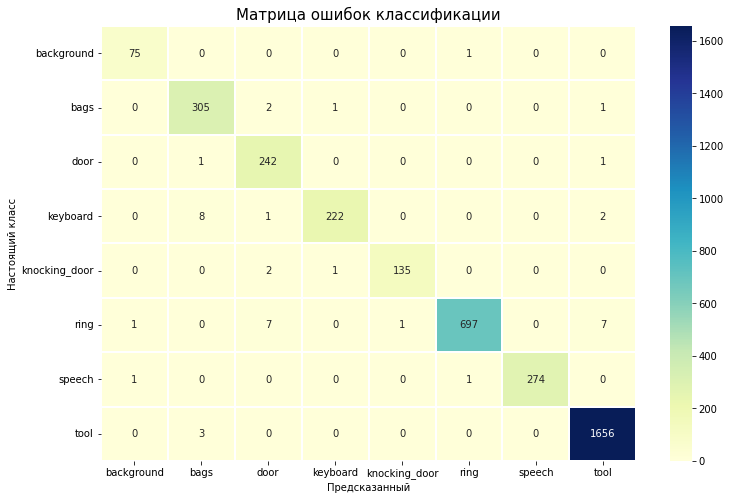

TEST PREDICTIONS:  0
##################################################
Fold:  1
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.2336 - acc: 0.1642
Epoch 00001: val_loss improved from inf to 1.95740, saving model to best_1.h5
13/13 [==============================] - 15s 1s/step - loss: 2.2336 - acc: 0.1642 - val_loss: 1.9574 - val_acc: 0.2521
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.6926 - acc: 0.3811
Epoch 00002: val_loss improved from 1.95740 to 1.83593, saving model to best_1.h5
13/13 [==============================] - 14s 1s/step - loss: 1.6926 - acc: 0.3811 - val_loss: 1.8359 - val_acc: 0.4548
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.4286 - acc: 0.5766
Epoch 00003: val_loss improved from 1.83593 to 1.70264, saving model to best_1.h5
13/13 [==============================] - 13s 1s/step - loss: 1.4286 - acc: 0.5766 - val_loss: 1.7026 - val_acc: 0.5890
Epoch 4/50
13/13 [==============================] - E

Epoch 30/50
13/13 [==============================] - ETA: 0s - loss: 0.2114 - acc: 0.9839
Epoch 00030: val_loss improved from 0.84111 to 0.82115, saving model to best_1.h5
13/13 [==============================] - 13s 1s/step - loss: 0.2114 - acc: 0.9839 - val_loss: 0.8211 - val_acc: 0.7616
Epoch 31/50
13/13 [==============================] - ETA: 0s - loss: 0.1995 - acc: 0.9842
Epoch 00031: val_loss improved from 0.82115 to 0.69270, saving model to best_1.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1995 - acc: 0.9842 - val_loss: 0.6927 - val_acc: 0.7918
Epoch 32/50
13/13 [==============================] - ETA: 0s - loss: 0.1898 - acc: 0.9909
Epoch 00032: val_loss did not improve from 0.69270
13/13 [==============================] - 13s 1s/step - loss: 0.1898 - acc: 0.9909 - val_loss: 0.7826 - val_acc: 0.7726
Epoch 33/50
13/13 [==============================] - ETA: 0s - loss: 0.1853 - acc: 0.9887
Epoch 00033: val_loss improved from 0.69270 to 0.67107, saving model

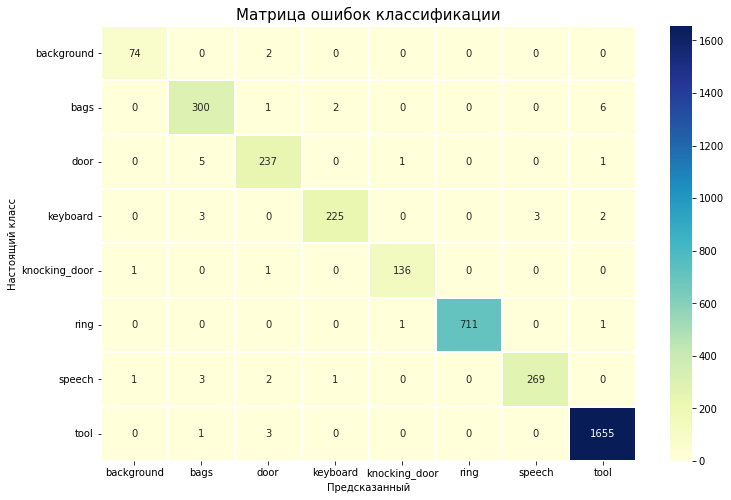

TEST PREDICTIONS:  1
##################################################
Fold:  2
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.9415 - acc: 0.2382
Epoch 00001: val_loss improved from inf to 2.00372, saving model to best_2.h5
13/13 [==============================] - 14s 1s/step - loss: 1.9415 - acc: 0.2382 - val_loss: 2.0037 - val_acc: 0.2466
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.4421 - acc: 0.5163
Epoch 00002: val_loss improved from 2.00372 to 1.85204, saving model to best_2.h5
13/13 [==============================] - 13s 993ms/step - loss: 1.4421 - acc: 0.5163 - val_loss: 1.8520 - val_acc: 0.3863
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.2342 - acc: 0.6369
Epoch 00003: val_loss improved from 1.85204 to 1.66920, saving model to best_2.h5
13/13 [==============================] - 13s 1s/step - loss: 1.2342 - acc: 0.6369 - val_loss: 1.6692 - val_acc: 0.6603
Epoch 4/50
13/13 [==============================] 

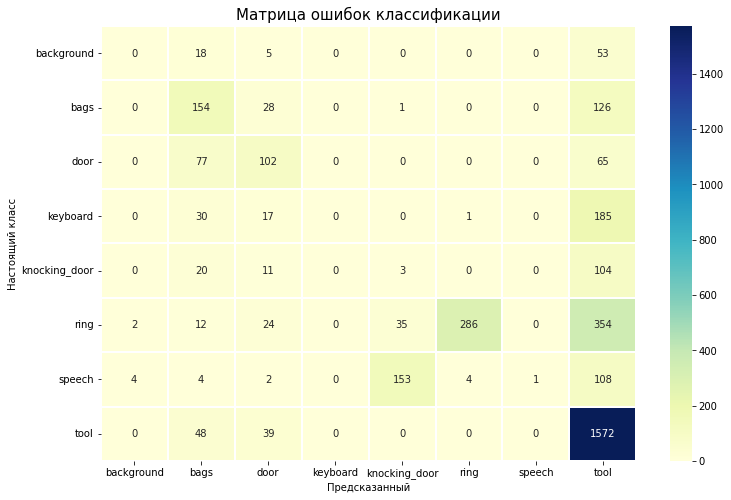

TEST PREDICTIONS:  2
##################################################
Fold:  3
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.6338 - acc: 0.4432
Epoch 00001: val_loss improved from inf to 1.93025, saving model to best_3.h5
13/13 [==============================] - 14s 1s/step - loss: 1.6338 - acc: 0.4432 - val_loss: 1.9302 - val_acc: 0.2685
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.2164 - acc: 0.6439
Epoch 00002: val_loss improved from 1.93025 to 1.74021, saving model to best_3.h5
13/13 [==============================] - 13s 1s/step - loss: 1.2164 - acc: 0.6439 - val_loss: 1.7402 - val_acc: 0.5973
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.0181 - acc: 0.7246
Epoch 00003: val_loss improved from 1.74021 to 1.66692, saving model to best_3.h5
13/13 [==============================] - 13s 1s/step - loss: 1.0181 - acc: 0.7246 - val_loss: 1.6669 - val_acc: 0.5753
Epoch 4/50
13/13 [==============================] - E

13/13 [==============================] - ETA: 0s - loss: 0.1368 - acc: 0.9945
Epoch 00030: val_loss improved from 1.03944 to 1.01287, saving model to best_3.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1368 - acc: 0.9945 - val_loss: 1.0129 - val_acc: 0.6575
Epoch 31/50
13/13 [==============================] - ETA: 0s - loss: 0.1314 - acc: 0.9933
Epoch 00031: val_loss improved from 1.01287 to 0.96597, saving model to best_3.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1314 - acc: 0.9933 - val_loss: 0.9660 - val_acc: 0.6630
Epoch 32/50
13/13 [==============================] - ETA: 0s - loss: 0.1252 - acc: 0.9942
Epoch 00032: val_loss improved from 0.96597 to 0.86939, saving model to best_3.h5
13/13 [==============================] - 13s 999ms/step - loss: 0.1252 - acc: 0.9942 - val_loss: 0.8694 - val_acc: 0.7151
Epoch 33/50
13/13 [==============================] - ETA: 0s - loss: 0.1201 - acc: 0.9957
Epoch 00033: val_loss improved from 0.86939 to

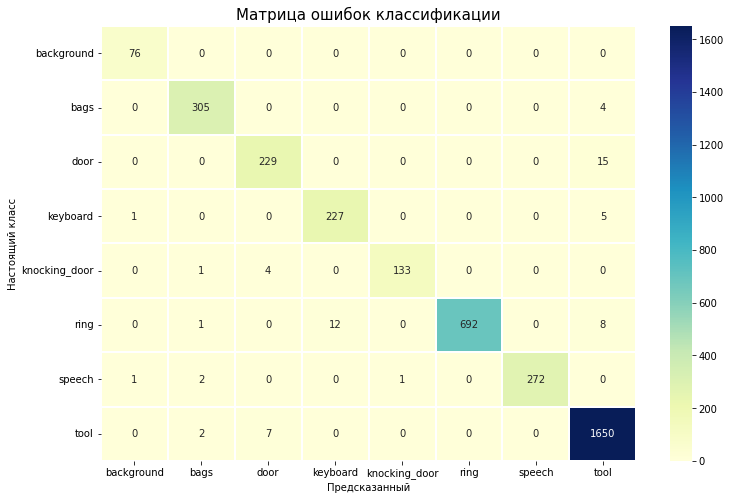

TEST PREDICTIONS:  3
##################################################
Fold:  4
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.7427 - acc: 0.4438
Epoch 00001: val_loss improved from inf to 1.95013, saving model to best_4.h5
13/13 [==============================] - 15s 1s/step - loss: 1.7427 - acc: 0.4438 - val_loss: 1.9501 - val_acc: 0.2356
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.2517 - acc: 0.6159
Epoch 00002: val_loss improved from 1.95013 to 1.70116, saving model to best_4.h5
13/13 [==============================] - 14s 1s/step - loss: 1.2517 - acc: 0.6159 - val_loss: 1.7012 - val_acc: 0.5808
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.0512 - acc: 0.6716
Epoch 00003: val_loss improved from 1.70116 to 1.59028, saving model to best_4.h5
13/13 [==============================] - 14s 1s/step - loss: 1.0512 - acc: 0.6716 - val_loss: 1.5903 - val_acc: 0.6247
Epoch 4/50
13/13 [==============================] - E

Epoch 30/50
13/13 [==============================] - ETA: 0s - loss: 0.1325 - acc: 0.9930
Epoch 00030: val_loss improved from 0.78188 to 0.69993, saving model to best_4.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1325 - acc: 0.9930 - val_loss: 0.6999 - val_acc: 0.7589
Epoch 31/50
13/13 [==============================] - ETA: 0s - loss: 0.1258 - acc: 0.9945
Epoch 00031: val_loss improved from 0.69993 to 0.68338, saving model to best_4.h5
13/13 [==============================] - 14s 1s/step - loss: 0.1258 - acc: 0.9945 - val_loss: 0.6834 - val_acc: 0.7644
Epoch 32/50
13/13 [==============================] - ETA: 0s - loss: 0.1204 - acc: 0.9951
Epoch 00032: val_loss improved from 0.68338 to 0.63559, saving model to best_4.h5
13/13 [==============================] - 16s 1s/step - loss: 0.1204 - acc: 0.9951 - val_loss: 0.6356 - val_acc: 0.7726
Epoch 33/50
13/13 [==============================] - ETA: 0s - loss: 0.1152 - acc: 0.9963
Epoch 00033: val_loss improved from 0

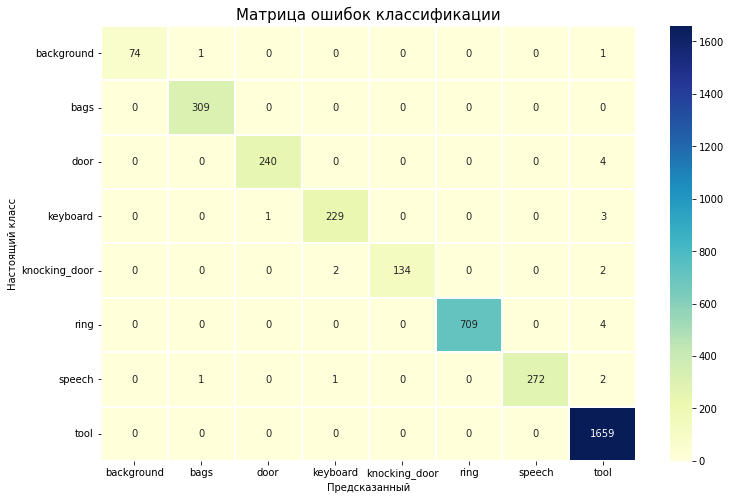

TEST PREDICTIONS:  4
##################################################
Fold:  5
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.8886 - acc: 0.3137
Epoch 00001: val_loss improved from inf to 2.07020, saving model to best_5.h5
13/13 [==============================] - 13s 973ms/step - loss: 1.8886 - acc: 0.3137 - val_loss: 2.0702 - val_acc: 0.2137
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.3776 - acc: 0.6058
Epoch 00002: val_loss improved from 2.07020 to 1.88881, saving model to best_5.h5
13/13 [==============================] - 13s 964ms/step - loss: 1.3776 - acc: 0.6058 - val_loss: 1.8888 - val_acc: 0.4849
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1637 - acc: 0.6802
Epoch 00003: val_loss improved from 1.88881 to 1.80290, saving model to best_5.h5
13/13 [==============================] - 13s 967ms/step - loss: 1.1637 - acc: 0.6802 - val_loss: 1.8029 - val_acc: 0.5288
Epoch 4/50
13/13 [==========================

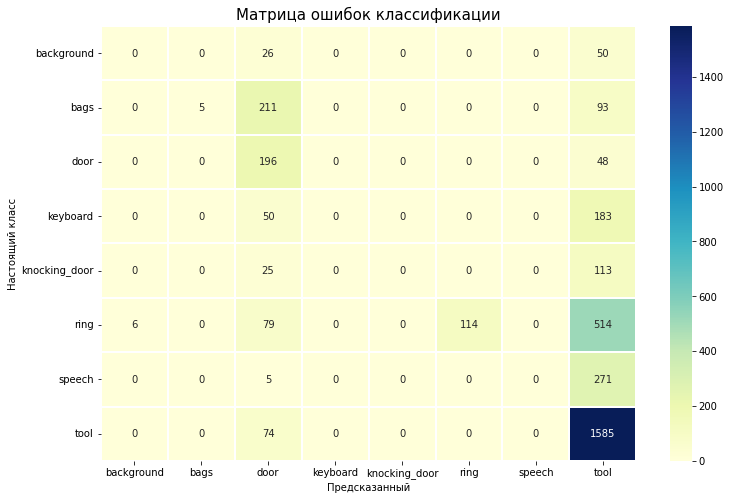

TEST PREDICTIONS:  5
##################################################
Fold:  6
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.8160 - acc: 0.3667
Epoch 00001: val_loss improved from inf to 1.94535, saving model to best_6.h5
13/13 [==============================] - 14s 1s/step - loss: 1.8160 - acc: 0.3667 - val_loss: 1.9453 - val_acc: 0.2849
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.3219 - acc: 0.6034
Epoch 00002: val_loss improved from 1.94535 to 1.79766, saving model to best_6.h5
13/13 [==============================] - 13s 1s/step - loss: 1.3219 - acc: 0.6034 - val_loss: 1.7977 - val_acc: 0.4658
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1073 - acc: 0.6628
Epoch 00003: val_loss improved from 1.79766 to 1.65322, saving model to best_6.h5
13/13 [==============================] - 13s 1s/step - loss: 1.1073 - acc: 0.6628 - val_loss: 1.6532 - val_acc: 0.6384
Epoch 4/50
13/13 [==============================] - E

Epoch 30/50
13/13 [==============================] - ETA: 0s - loss: 0.1471 - acc: 0.9915
Epoch 00030: val_loss improved from 0.87382 to 0.87209, saving model to best_6.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1471 - acc: 0.9915 - val_loss: 0.8721 - val_acc: 0.6904
Epoch 31/50
13/13 [==============================] - ETA: 0s - loss: 0.1394 - acc: 0.9921
Epoch 00031: val_loss improved from 0.87209 to 0.77947, saving model to best_6.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1394 - acc: 0.9921 - val_loss: 0.7795 - val_acc: 0.7068
Epoch 32/50
13/13 [==============================] - ETA: 0s - loss: 0.1354 - acc: 0.9924
Epoch 00032: val_loss improved from 0.77947 to 0.76605, saving model to best_6.h5
13/13 [==============================] - 13s 1s/step - loss: 0.1354 - acc: 0.9924 - val_loss: 0.7661 - val_acc: 0.7123
Epoch 33/50
13/13 [==============================] - ETA: 0s - loss: 0.1278 - acc: 0.9936
Epoch 00033: val_loss improved from 0

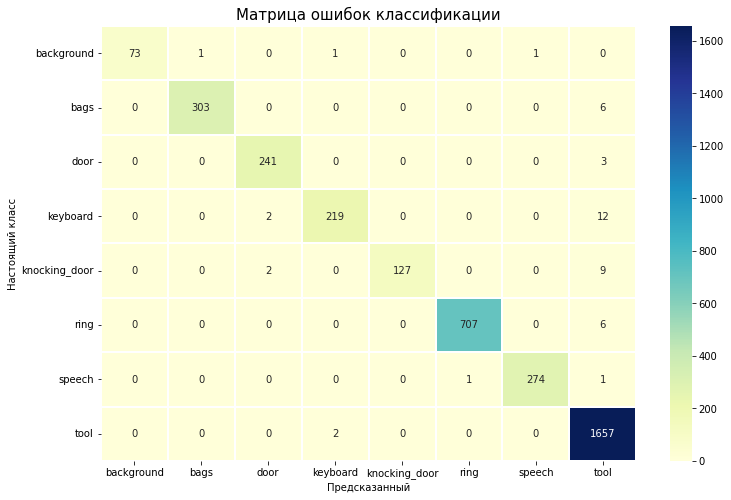

TEST PREDICTIONS:  6
##################################################
Fold:  7
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 1.8042 - acc: 0.3512
Epoch 00001: val_loss improved from inf to 2.03777, saving model to best_7.h5
13/13 [==============================] - 13s 969ms/step - loss: 1.8042 - acc: 0.3512 - val_loss: 2.0378 - val_acc: 0.3014
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.3482 - acc: 0.6013
Epoch 00002: val_loss improved from 2.03777 to 1.80427, saving model to best_7.h5
13/13 [==============================] - 12s 962ms/step - loss: 1.3482 - acc: 0.6013 - val_loss: 1.8043 - val_acc: 0.4548
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.1553 - acc: 0.6826
Epoch 00003: val_loss improved from 1.80427 to 1.64674, saving model to best_7.h5
13/13 [==============================] - 12s 959ms/step - loss: 1.1553 - acc: 0.6826 - val_loss: 1.6467 - val_acc: 0.6055
Epoch 4/50
13/13 [==========================

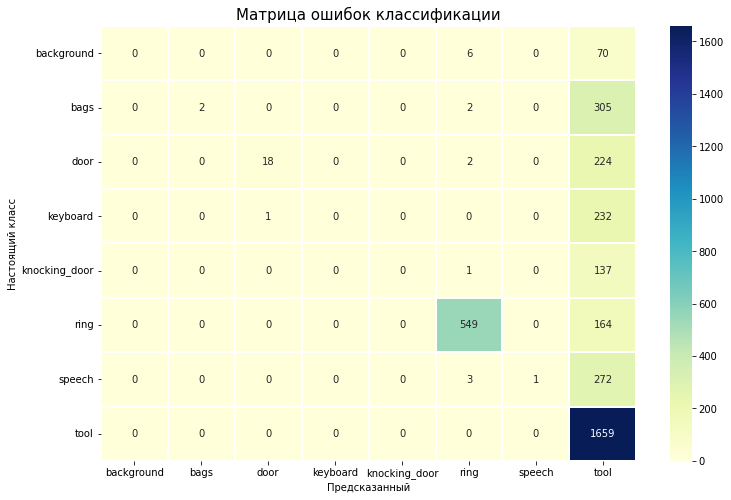

TEST PREDICTIONS:  7
##################################################
Fold:  8
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.0385 - acc: 0.2153
Epoch 00001: val_loss improved from inf to 2.00065, saving model to best_8.h5
13/13 [==============================] - 14s 1s/step - loss: 2.0385 - acc: 0.2153 - val_loss: 2.0006 - val_acc: 0.2115
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.4855 - acc: 0.5140
Epoch 00002: val_loss improved from 2.00065 to 1.88722, saving model to best_8.h5
13/13 [==============================] - 13s 1s/step - loss: 1.4855 - acc: 0.5140 - val_loss: 1.8872 - val_acc: 0.2830
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.2663 - acc: 0.6477
Epoch 00003: val_loss improved from 1.88722 to 1.72947, saving model to best_8.h5
13/13 [==============================] - 13s 1s/step - loss: 1.2663 - acc: 0.6477 - val_loss: 1.7295 - val_acc: 0.4918
Epoch 4/50
13/13 [==============================] - E

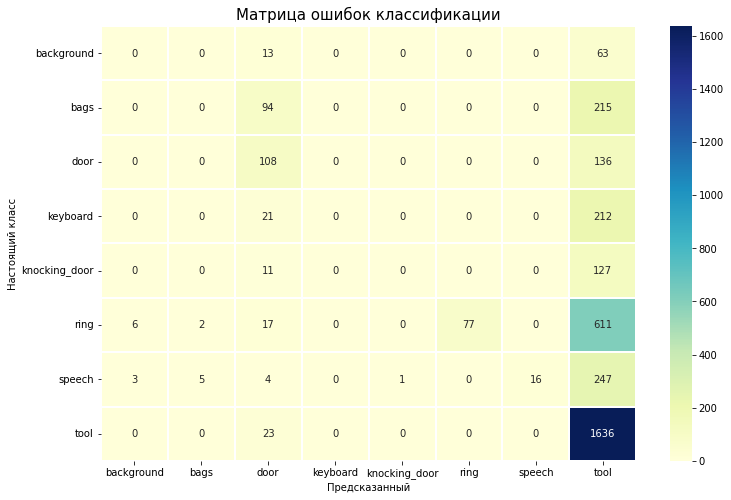

TEST PREDICTIONS:  8
##################################################
Fold:  9
Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 2.0725 - acc: 0.2199
Epoch 00001: val_loss improved from inf to 2.11904, saving model to best_9.h5
13/13 [==============================] - 14s 991ms/step - loss: 2.0725 - acc: 0.2199 - val_loss: 2.1190 - val_acc: 0.0824
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 1.4475 - acc: 0.5280
Epoch 00002: val_loss improved from 2.11904 to 2.03661, saving model to best_9.h5
13/13 [==============================] - 13s 1s/step - loss: 1.4475 - acc: 0.5280 - val_loss: 2.0366 - val_acc: 0.2775
Epoch 3/50
13/13 [==============================] - ETA: 0s - loss: 1.2088 - acc: 0.6815
Epoch 00003: val_loss improved from 2.03661 to 1.97990, saving model to best_9.h5
13/13 [==============================] - 13s 1s/step - loss: 1.2088 - acc: 0.6815 - val_loss: 1.9799 - val_acc: 0.4313
Epoch 4/50
13/13 [==============================] 

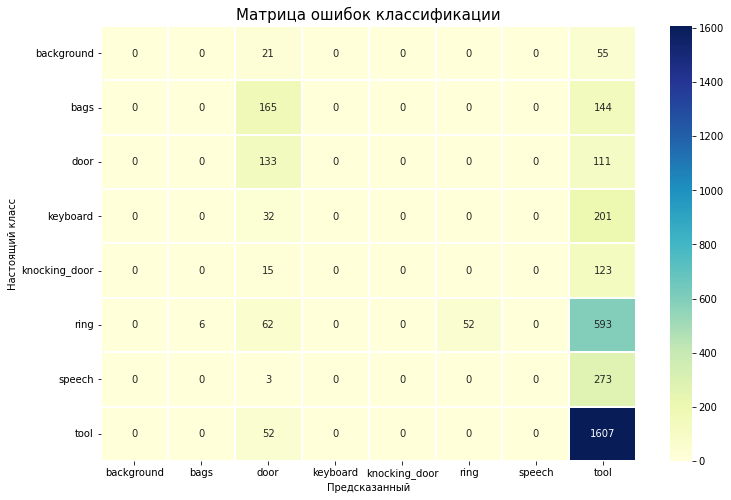

TEST PREDICTIONS:  9


In [ ]:
# Для кросс-валидации используется StratifiedKFold - разновдность KFold алгоритма, которая возвращает
# стратифицированные папки c данными: каждый набор в папке содержит примерно такой же процент выборок каждого целевого класса,
# что и полный набор.
skf = StratifiedKFold(n_splits=config.n_folds)
y_train = df["label"].values
y_train = np.stack(y_train[:])
model = get_2d_conv_model(config)
i = 0
for train_split, val_split in skf.split(X_train, y_train):
    K.clear_session()
    
    # Разделение имеющегося набора данных на тренировочную и валидационные выборки
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    
    # Callback-функции для модели Keras
    # В ходе обучения сохраняем веса лучшей модели для потенциального дальнейшего использования
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    callbacks_list = [checkpoint, early]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, batch_size=256, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)
    
    # Сохраняем предсказания модели по тренировочным данным
    print("TRAIN PREDICTIONS: ", i)
    predictions = model.predict(X_train, batch_size=256)
    save_train_preds_path = "./predictions/train_predictions_{:d}.npy".format(i)
    np.save(save_train_preds_path, predictions)
    plot_confusion_matrix(predictions, y_train)
    
    # Сохраняем предсказания модели по тестовым данным
    print("TEST PREDICTIONS: ", i)
    predictions = model.predict(X_test, batch_size=256)
    save_test_preds_path = "./predictions/test_predictions_{:d}.npy".format(i)
    np.save(save_test_preds_path, predictions)

    # # Создание файла с результатами (submission)
    # top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
    # predicted_labels = [' '.join(list(x)) for x in top_3]
    # df_test['label'] = predicted_labels
    # save_preds_path = "./predictions/predictions_{:d}.npy".format(i)
    # df_test[['label']].to_csv(save_preds_path)
    
    j = 0
    for prob in predictions:
        #print(prob)
        #print(np.argmax(prob))
        submission.loc[j,'score'] = max(prob)
        prob_index = list(prob).index(max(prob))
        #print(prob_index)
        submission.loc[j,'label'] = prob_index
        j += 1

    submission_result = submission.copy()
    submission_result['label'] = encode.inverse_transform(np.array(submission['label']).astype(int))
    submission = submission_result
    save_submission_path = "./predictions/submission_{:d}.npy".format(i)
    submission.to_csv(save_submission_path.format(i), index=False)
    
    i += 1